In [ ]:
import math

import torch

import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn.functional as F
import numpy as np
from torch.nn import init

import sys

import pickle as pkl

import networkx as nx
import scipy.sparse as sp

from __future__ import division
from __future__ import print_function

import time

import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
class MLPLayer(Module):
    def __init__(self, in_features, out_features, bias=True):
        super(MLPLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.normal_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.normal_(-stdv, stdv)

    def forward(self, input):
        output = torch.mm(input, self.weight)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [ ]:
class GraphConvolution(Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.normal_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.normal_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [ ]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, input_droprate, hidden_droprate, use_bn=False):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.input_droprate = input_droprate
        self.hidden_droprate = hidden_droprate
        self.bn1 = nn.BatchNorm1d(nfeat)
        self.bn2 = nn.BatchNorm1d(nhid)
        self.use_bn = use_bn

    def forward(self, x, adj):

        if self.use_bn:
            x = self.bn1(x)
        x = F.dropout(x, self.input_droprate, training=self.training)
        
        x = F.relu(self.gc1(x, adj))
        if self.use_bn:
            x = self.bn2(x)
        x = F.dropout(x, self.hidden_droprate, training=self.training)
        x = self.gc2(x, adj)

        return x


In [ ]:
class MLP(nn.Module):
    def __init__(self, nfeat, nhid, nclass, input_droprate, hidden_droprate, is_cuda=True, use_bn =False):
        super(MLP, self).__init__()

        self.layer1 = MLPLayer(nfeat, nhid)
        self.layer2 = MLPLayer(nhid, nclass)

        self.input_droprate = input_droprate
        self.hidden_droprate = hidden_droprate
        self.is_cuda = is_cuda
        self.bn1 = nn.BatchNorm1d(nfeat)
        self.bn2 = nn.BatchNorm1d(nhid)
        self.use_bn = use_bn
        
    def forward(self, x):
         
        if self.use_bn: 
            x = self.bn1(x)
        x = F.dropout(x, self.input_droprate, training=self.training)
        x = F.relu(self.layer1(x))
        if self.use_bn:
            x = self.bn2(x)
        x = F.dropout(x, self.hidden_droprate, training=self.training)
        x = self.layer2(x)

        return x

In [ ]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

In [ ]:
def load_data(dataset_str = 'cora'):
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("/content/drive/MyDrive/GRAND_data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))
    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("/content/drive/MyDrive/GRAND_data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    features = normalize(features)
    graph = nx.from_dict_of_lists(graph)
    adj = nx.adjacency_matrix(graph)
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    
    adj = adj + sp.eye(adj.shape[0])
    D1_ = np.array(adj.sum(axis=1))**(-0.5)
    D2_ = np.array(adj.sum(axis=0))**(-0.5)
    D1_ = sp.diags(D1_[:,0], format='csr')
    D2_ = sp.diags(D2_[0,:], format='csr')
    A_ = adj.dot(D1_)
    A_ = D2_.dot(A_)
    
    
    D1 = np.array(adj.sum(axis=1))**(-0.5)
    D2 = np.array(adj.sum(axis=0))**(-0.5)
    D1 = sp.diags(D1[:,0], format='csr')
    D2 = sp.diags(D2[0,:], format='csr')
    
    A = adj.dot(D1)
    A = D2.dot(A)


    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]     # onehot

    idx_train = range(len(y))
    idx_val = range(len(y), len(y)+500)
    idx_test = test_idx_range.tolist()

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.argmax(labels, -1))
    A = sparse_mx_to_torch_sparse_tensor(A)
    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return A, adj, features, labels, idx_train, idx_val, idx_test, graph.edges()

In [ ]:
def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

def normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [ ]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def label_vector_generator(adj, label_vector, index = [], order=1, shuffle=False, style=0):
    label_vectors = []
    lv = torch.zeros(label_vector.shape)
    lv[index, :] = label_vector[index, :]
    for i in range(order):
        label_vectors.append(lv)
        if i!= (order-1):
            lv = torch.spmm(adj, lv)
    if style == 0:
        return sum(label_vectors)*1.0/order
    return torch.cat(label_vectors, 1)

In [ ]:
def feature_generator(adj, features, order=0):
    n = features.shape[0]
    index = np.random.permutation(n)
    index_1 = index[: n//2]
    index_2 = index[n//2 :]
    mask_1 = torch.zeros(n,1)
    mask_2 = torch.zeros(n,1)
    mask_1[index_1] = 1
    mask_2[index_2] = 1

    features_1 = [mask_1.cuda() * features]
    features_2 = [mask_2.cuda() * features]

    alpha = 1
    for i in range(order):
        features_1.append(alpha*torch.spmm(adj, features_1[-1]) + (1-alpha)*features_1[0])
    for i in range(order):
        features_2.append(alpha*torch.spmm(adj, features_2[-1]) + (1-alpha)*features_2[0])

    return sum(features_1)*1./(order+1), sum(features_2)*1./(order+1)

In [ ]:
def MMD(x, y, alpha=0.5):
    n_x, n_y = x.size(0), y.size(0)

    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    rrx = (xx.diag().unsqueeze(1).expand(n_x, n_y))
    rry = (yy.diag().unsqueeze(0).expand(n_x, n_y))

    K = torch.exp(- alpha * (rx.t() + rx - 2*xx))
    L = torch.exp(- alpha * (ry.t() + ry - 2*yy))
    P = torch.exp(- alpha * (rrx + rry - 2*zz))

    loss = 1./(n_x*(n_x-1)) * torch.sum(K) + 1./(n_y*(n_y-1)) * torch.sum(L) - (2./(n_x*n_y)) * torch.sum(P)

    return 0.5*loss

def MMD_same(x, y, alpha=0.5):
    n_x, n_y = x.size(0), y.size(0)

    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    K = torch.exp(- alpha * (rx.t() + rx - 2*xx))
    L = torch.exp(- alpha * (ry.t() + ry - 2*yy))
    P = torch.exp(- alpha * (rx.t() + ry - 2*zz))

    loss = 1./(n_x*(n_x-1)) * torch.sum(K) + 1./(n_y*(n_y-1)) * torch.sum(L) - (2./(n_x*n_y)) * torch.sum(P)

    return loss

In [ ]:
args = {
    'cuda': True,
    'fastmode': False,
    'seed': 42,
    'epochs': 5000,
    'lr': 0.01,
    'weight_decay': 5e-4,
    'hidden': 32,
    'input_droprate': 0.5,
    'hidden_droprate': 0.5,
    'dropnode_rate': 0.5,
    'patience': 100,
    'order': 5,
    'sample': 4,
    'tem': 0.5,
    'lam': 1.,
    'dataset': 'pubmed',
    'use_bn': False,
    'dropout': 0.5
}

In [ ]:
#cora
args['lam'] = 1.0 
args['tem'] = 0.5 
args['order'] = 8 
args['sample'] = 4 
args['dataset'] = 'cora' 
args['input_droprate'] = 0.5 
args['hidden_droprate'] = 0.5 
args['hidden'] = 32 
args['lr'] = 0.01 
args['patience'] = 200
args['seed'] = 100 
args['dropnode_rate'] = 0.5

In [ ]:
#pubmed
args['lam'] = 1.0 
args['tem'] = 0.2 
args['order'] = 5
args['sample'] = 4 
args['dataset'] = 'pubmed' 
args['input_droprate'] = 0.6 
args['hidden_droprate'] = 0.8 
args['hidden'] = 32 
args['lr'] = 0.2 
args['patience'] = 100 
args['dropnode_rate'] = 0.5
args['use_bn'] = True

In [ ]:
#citeseer
args['lam'] = 0.7 
args['tem'] = 0.3 
args['order'] = 2
args['sample'] = 2 
args['dataset'] = 'citeseer' 
args['input_droprate'] = 0.0 
args['hidden_droprate'] = 0.2 
args['hidden'] = 32 
args['lr'] = 0.01 
args['patience'] = 200 
args['dropnode_rate'] = 0.5
args['seed'] = 100

In [ ]:
scaler = StandardScaler()
dataset = args['dataset']
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])
if args['cuda']:
  torch.cuda.manual_seed(args['seed'])

# Load data
A, adj, features, labels, idx_train, idx_val, idx_test, edges = load_data(dataset)
idx_unlabel = torch.range(idx_train.shape[0], labels.shape[0]-1, dtype=int)

# Model and optimizer
model = MLP(nfeat=features.shape[1],
            nhid=args['hidden'],
            nclass=labels.max().item() + 1,
            input_droprate=args['input_droprate'],
            hidden_droprate=args['hidden_droprate'],
            use_bn = args['use_bn'])
optimizer = optim.Adam(model.parameters(),
                       lr=args['lr'], weight_decay=args['weight_decay'])

if args['cuda']:
    model.cuda()
    features = features.cuda()
    A = A.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()
    idx_unlabel = idx_unlabel.cuda()

def propagate(feature, A, order):
    #feature = F.dropout(feature, args.dropout, training=training)
    x = feature
    y = feature
    for i in range(order):
        x = torch.spmm(A, x).detach_()
        #print(y.add_(x))
        y.add_(x)
        
    return y.div_(order+1.0).detach_()

def rand_prop(features, training, order = args['order']):
    n = features.shape[0]
    drop_rate = args['dropnode_rate']
    drop_rates = torch.FloatTensor(np.ones(n) * drop_rate)
    
    if training:
            
        masks = torch.bernoulli(1. - drop_rates).unsqueeze(1)

        features = masks.cuda() * features
            
    else:
            
        features = features * (1. - drop_rate)
    features = propagate(features, A, order)    
    return features

def consis_loss(logps, temp=args['tem'], lam = args['lam']):
    ps = [torch.exp(p) for p in logps]
    sum_p = 0.
    for p in ps:
        sum_p = sum_p + p
    avg_p = sum_p/len(ps)
    #p2 = torch.exp(logp2)
    
    sharp_p = (torch.pow(avg_p, 1./temp) / torch.sum(torch.pow(avg_p, 1./temp), dim=1, keepdim=True)).detach()
    loss = 0.
    for p in ps:
        loss += torch.mean((p-sharp_p).pow(2).sum(1))
    loss = loss/len(ps)
    return lam * loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#Dropedge/Dropout
scaler = StandardScaler()
dataset = args['dataset']
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])
if args['cuda']:
  torch.cuda.manual_seed(args['seed'])
# Load data
A, adj, features, labels, idx_train, idx_val, idx_test, edges = load_data(dataset)
idx_unlabel = torch.range(idx_train.shape[0], labels.shape[0]-1, dtype=int)
# Model and optimizer
model = MLP(nfeat=features.shape[1],
            nhid=args['hidden'],
            nclass=labels.max().item() + 1,
            input_droprate=args['input_droprate'],
            hidden_droprate=args['hidden_droprate'],
            use_bn = args['use_bn'])
optimizer = optim.Adam(model.parameters(),
                       lr=args['lr'], weight_decay=args['weight_decay'])

if args['cuda']:
    model.cuda()
    features = features.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()
    idx_unlabel = idx_unlabel.cuda()
    A = A.cuda()

def propagate(feature, a, order):
    #feature = F.dropout(feature, args['dropout'], training=training)
    #x = feature
    y = torch.spmm(a,feature).detach_()
    x = y
    for i in range(order):
        if i ==0:
            x = torch.spmm(a, x).detach_()
        else:
            x = torch.spmm(a, x).detach_()
        #print(y.add_(x))
        y.add_(x)
        #y= x
    return y.div_(order+1.0).detach_()
def sparse_dropout(a, training, dropedge_rate):
    indice = a._indices()
    values = a._values() 
    values = F.dropout(values, p=dropedge_rate, training=training)
    size = a.size()
    a = torch.sparse.FloatTensor(indice, values, size)
    #d1 = torch.diag(a.sum(dim=1)**(-0.5))
    #d2 = torch.diag(a.sum(dim=0)**(-0.5))
    
    return a
def preprocess(a):
    #d1 = np.array(a.sum(axis-1))**(-0.5)
    #d2 = np.array(a.sum(axis=0))**(-0.5)
    D1_ = np.array(a.sum(axis=1))**(-0.5)
    D2_ = np.array(a.sum(axis=0))**(-0.5)
    D1_ = sp.diags(D1_[:,0], format='csr')
    D2_ = sp.diags(D2_[0,:], format='csr')
    A_ = a.dot(D1_)
    A_ = D2_.dot(A_)
    A_ = sparse_mx_to_torch_sparse_tensor(A_) 
    if args['cuda']:
        A_ = A_.cuda()
    return A_    


def random_edge_sample(edges, droprate):
    edges = list(edges)
    n = features.shape[0]
    m = len(edges)
    index = np.random.permutation(m)
    percent = 1. - droprate
    preserve_num = int(m * percent)
     
    index_ = index[:preserve_num]
    sample_row = [edges[x][0] for x in index_]
    sample_col = [edges[x][1] for x in index_]
    sample_adj = sp.csr_matrix((np.ones(preserve_num), (sample_row, sample_col)), shape=(n,n))
    sample_adj = sample_adj + sample_adj.T.multiply(sample_adj.T>sample_adj) - sample_adj.multiply(sample_adj.T>sample_adj) + sp.eye(n)
    sample_adj = preprocess(sample_adj)
    return sample_adj                          
    
    
def rand_prop(features, training, order = args['order']):
    n = features.shape[0]
    drop_rate = args['dropnode_rate']
    #drop_rates = torch.FloatTensor(np.ones(n) * drop_rate)
    if training: 
        #a = random_edge_sample(edges, drop_rate)
        a = sparse_dropout(A, training, drop_rate)
    else:
        a = A#preprocess(adj)
    features = propagate(features, a, order)    
    return features

def consis_loss(logps, temp=args['tem'], lam = args['lam']):
    ps = [torch.exp(p) for p in logps]
    sum_p = 0.
    for p in ps:
        sum_p = sum_p + p
    avg_p = sum_p/len(ps)
    #p2 = torch.exp(logp2)
    
    sharp_p = (torch.pow(avg_p, 1./temp) / torch.sum(torch.pow(avg_p, 1./temp), dim=1, keepdim=True)).detach()
    loss = 0.
    for p in ps:
        loss += torch.mean((p-sharp_p).pow(2).sum(1))
    loss = loss/len(ps)
    return lam * loss


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
def train(epoch, order=args['order'], lam=args['order'], sample = args['sample']):
    t = time.time()
    
    X = features
    
    model.train()
    optimizer.zero_grad()
    X_list = []
    K = sample
    for k in range(K):
        X_list.append(rand_prop(X, training=True, order=order))

    output_list = []
    for k in range(K):
        output_list.append(torch.log_softmax(model(X_list[k]), dim=-1))

    
    loss_train = 0.
    for k in range(K):
        loss_train += F.nll_loss(output_list[k][idx_train], labels[idx_train])
     
        
    loss_train = loss_train/K
    #loss_train = F.nll_loss(output_1[idx_train], labels[idx_train]) + F.nll_loss(output_1[idx_train], labels[idx_train])
    #loss_js = js_loss(output_1[idx_unlabel], output_2[idx_unlabel])
    #loss_en = entropy_loss(output_1[idx_unlabel]) + entropy_loss(output_2[idx_unlabel])
    loss_consis = consis_loss(output_list, lam=lam)

    loss_train = loss_train + loss_consis
    acc_train = accuracy(output_list[0][idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not args['fastmode']:
        model.eval()
        X = rand_prop(X,training=False, order=order)
        output = model(X)
        output = torch.log_softmax(output, dim=-1)
        
    loss_val = F.nll_loss(output[idx_val], labels[idx_val]) 
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    return loss_val.item(), acc_val.item()

In [ ]:
def Train(order = args['order'], lam = args['lam'], sample = args['sample']):
    # Train model
    t_total = time.time()
    loss_values = []
    acc_values = []
    bad_counter = 0
    # best = args.epochs + 1
    loss_best = np.inf
    acc_best = 0.0

    loss_mn = np.inf
    acc_mx = 0.0

    best_epoch = 0

    for epoch in range(args['epochs']):
        # if epoch < 200:
        #   l, a = train(epoch, True)
        #   loss_values.append(l)
        #   acc_values.append(a)
        #   continue

        l, a = train(epoch, order, lam, sample)
        loss_values.append(l)
        acc_values.append(a)

        print(bad_counter)

        if loss_values[-1] <= loss_mn or acc_values[-1] >= acc_mx:# or epoch < 400:
            if loss_values[-1] <= loss_best: #and acc_values[-1] >= acc_best:
                loss_best = loss_values[-1]
                acc_best = acc_values[-1]
                best_epoch = epoch
                torch.save(model.state_dict(), dataset +'.pkl')

            loss_mn = np.min((loss_values[-1], loss_mn))
            acc_mx = np.max((acc_values[-1], acc_mx))
            bad_counter = 0
        else:
            bad_counter += 1

        # print(bad_counter, loss_mn, acc_mx, loss_best, acc_best, best_epoch)
        if bad_counter == args['patience']:
            print('Early stop! Min loss: ', loss_mn, ', Max accuracy: ', acc_mx)
            print('Early stop model validation loss: ', loss_best, ', accuracy: ', acc_best)
            break

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

    # Restore best model
    print('Loading {}th epoch'.format(best_epoch))
    model.load_state_dict(torch.load(dataset +'.pkl'))

In [ ]:
def test(order = args['order']):
    model.eval()
    X = features
    X = rand_prop(X, training=False, order=order)
    output = model(X)
    output = torch.log_softmax(output, dim=-1)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    return acc_test

In [ ]:
Train() #cora
test()

Epoch: 0001 loss_train: 2.0150 acc_train: 0.1429 loss_val: 1.9731 acc_val: 0.1140 time: 0.0522s
0
Epoch: 0002 loss_train: 2.0125 acc_train: 0.1429 loss_val: 1.9696 acc_val: 0.1140 time: 0.0462s
0
Epoch: 0003 loss_train: 2.0017 acc_train: 0.1429 loss_val: 1.9666 acc_val: 0.1140 time: 0.0459s
0
Epoch: 0004 loss_train: 1.9969 acc_train: 0.1429 loss_val: 1.9632 acc_val: 0.1140 time: 0.0456s
0
Epoch: 0005 loss_train: 1.9914 acc_train: 0.1429 loss_val: 1.9606 acc_val: 0.1140 time: 0.0470s
0
Epoch: 0006 loss_train: 1.9847 acc_train: 0.1357 loss_val: 1.9582 acc_val: 0.1140 time: 0.0442s
0
Epoch: 0007 loss_train: 1.9810 acc_train: 0.1429 loss_val: 1.9564 acc_val: 0.1140 time: 0.0438s
0
Epoch: 0008 loss_train: 1.9742 acc_train: 0.1357 loss_val: 1.9549 acc_val: 0.1140 time: 0.0470s
0
Epoch: 0009 loss_train: 1.9686 acc_train: 0.1286 loss_val: 1.9537 acc_val: 0.1140 time: 0.0460s
0
Epoch: 0010 loss_train: 1.9608 acc_train: 0.1714 loss_val: 1.9526 acc_val: 0.1140 time: 0.0459s
0
Epoch: 0011 loss_tra

In [ ]:
Train() #pubmed
test()

Epoch: 0001 loss_train: 5.8801 acc_train: 0.4000 loss_val: 2.0198 acc_val: 0.4160 time: 0.1196s
0
Epoch: 0002 loss_train: 2.8835 acc_train: 0.4167 loss_val: 1.1967 acc_val: 0.4160 time: 0.1148s
0
Epoch: 0003 loss_train: 1.8585 acc_train: 0.3667 loss_val: 1.0934 acc_val: 0.3880 time: 0.1092s
0
Epoch: 0004 loss_train: 1.5998 acc_train: 0.3167 loss_val: 1.1389 acc_val: 0.3880 time: 0.1100s
0
Epoch: 0005 loss_train: 1.6219 acc_train: 0.4000 loss_val: 1.1209 acc_val: 0.3880 time: 0.1094s
1
Epoch: 0006 loss_train: 1.6589 acc_train: 0.3000 loss_val: 1.0833 acc_val: 0.4160 time: 0.1095s
2
Epoch: 0007 loss_train: 1.5294 acc_train: 0.3000 loss_val: 1.2114 acc_val: 0.4160 time: 0.1093s
0
Epoch: 0008 loss_train: 1.7527 acc_train: 0.3500 loss_val: 1.2540 acc_val: 0.4160 time: 0.1092s
0
Epoch: 0009 loss_train: 1.5857 acc_train: 0.4000 loss_val: 1.1632 acc_val: 0.4160 time: 0.1091s
0
Epoch: 0010 loss_train: 1.5027 acc_train: 0.3667 loss_val: 1.1037 acc_val: 0.4160 time: 0.1094s
0
Epoch: 0011 loss_tra

In [ ]:
Train() #citeseer
test()

Epoch: 0001 loss_train: 1.9142 acc_train: 0.1667 loss_val: 1.8114 acc_val: 0.2320 time: 0.0225s
0
Epoch: 0002 loss_train: 1.9087 acc_train: 0.1667 loss_val: 1.8098 acc_val: 0.2320 time: 0.0199s
0
Epoch: 0003 loss_train: 1.9000 acc_train: 0.1667 loss_val: 1.8083 acc_val: 0.2320 time: 0.0200s
0
Epoch: 0004 loss_train: 1.8987 acc_train: 0.1667 loss_val: 1.8068 acc_val: 0.2320 time: 0.0196s
0
Epoch: 0005 loss_train: 1.8957 acc_train: 0.1667 loss_val: 1.8053 acc_val: 0.2320 time: 0.0195s
0
Epoch: 0006 loss_train: 1.8935 acc_train: 0.1667 loss_val: 1.8036 acc_val: 0.2320 time: 0.0196s
0
Epoch: 0007 loss_train: 1.8899 acc_train: 0.1667 loss_val: 1.8017 acc_val: 0.2320 time: 0.0196s
0
Epoch: 0008 loss_train: 1.8838 acc_train: 0.1667 loss_val: 1.8000 acc_val: 0.2320 time: 0.0197s
0
Epoch: 0009 loss_train: 1.8817 acc_train: 0.1667 loss_val: 1.7983 acc_val: 0.2320 time: 0.0196s
0
Epoch: 0010 loss_train: 1.8787 acc_train: 0.1667 loss_val: 1.7967 acc_val: 0.2320 time: 0.0191s
0
Epoch: 0011 loss_tra

In [ ]:
Train(lam=0) #cora
test()

Epoch: 0001 loss_train: 2.0268 acc_train: 0.1286 loss_val: 2.0262 acc_val: 0.1140 time: 0.2243s
0
Epoch: 0002 loss_train: 2.0199 acc_train: 0.1429 loss_val: 2.0207 acc_val: 0.1140 time: 0.0466s
0
Epoch: 0003 loss_train: 2.0124 acc_train: 0.1500 loss_val: 2.0149 acc_val: 0.1140 time: 0.0468s
0
Epoch: 0004 loss_train: 2.0090 acc_train: 0.1571 loss_val: 2.0089 acc_val: 0.1140 time: 0.0467s
0
Epoch: 0005 loss_train: 2.0038 acc_train: 0.1500 loss_val: 2.0030 acc_val: 0.1140 time: 0.0471s
0
Epoch: 0006 loss_train: 1.9958 acc_train: 0.1286 loss_val: 1.9972 acc_val: 0.1140 time: 0.0445s
0
Epoch: 0007 loss_train: 1.9929 acc_train: 0.1214 loss_val: 1.9917 acc_val: 0.1140 time: 0.0462s
0
Epoch: 0008 loss_train: 1.9877 acc_train: 0.1429 loss_val: 1.9864 acc_val: 0.1140 time: 0.0461s
0
Epoch: 0009 loss_train: 1.9812 acc_train: 0.1286 loss_val: 1.9813 acc_val: 0.1140 time: 0.0461s
0
Epoch: 0010 loss_train: 1.9775 acc_train: 0.1429 loss_val: 1.9764 acc_val: 0.1140 time: 0.0471s
0
Epoch: 0011 loss_tra

tensor(0.8450, device='cuda:0', dtype=torch.float64)

In [ ]:
Train(lam=0) #pubmed
test()

Epoch: 0001 loss_train: 5.2474 acc_train: 0.4333 loss_val: 2.0049 acc_val: 0.4160 time: 0.1588s
0
Epoch: 0002 loss_train: 2.9157 acc_train: 0.4000 loss_val: 1.1156 acc_val: 0.4160 time: 0.1444s
0
Epoch: 0003 loss_train: 1.2248 acc_train: 0.6333 loss_val: 1.0686 acc_val: 0.3880 time: 0.1472s
0
Epoch: 0004 loss_train: 1.2495 acc_train: 0.5167 loss_val: 1.0772 acc_val: 0.3880 time: 0.1443s
0
Epoch: 0005 loss_train: 1.2806 acc_train: 0.5000 loss_val: 1.0813 acc_val: 0.4160 time: 0.1459s
1
Epoch: 0006 loss_train: 1.3184 acc_train: 0.4333 loss_val: 1.1581 acc_val: 0.4160 time: 0.1453s
0
Epoch: 0007 loss_train: 1.2430 acc_train: 0.5167 loss_val: 1.1059 acc_val: 0.4160 time: 0.1455s
0
Epoch: 0008 loss_train: 1.1276 acc_train: 0.3833 loss_val: 1.0676 acc_val: 0.3880 time: 0.1448s
0
Epoch: 0009 loss_train: 1.1118 acc_train: 0.4500 loss_val: 1.0643 acc_val: 0.3880 time: 0.1448s
0
Epoch: 0010 loss_train: 1.0740 acc_train: 0.4333 loss_val: 1.0667 acc_val: 0.4160 time: 0.1443s
0
Epoch: 0011 loss_tra

tensor(0.8110, device='cuda:0', dtype=torch.float64)

In [ ]:
Train(lam=0) #citeseer
test()

Epoch: 0001 loss_train: 1.8608 acc_train: 0.1667 loss_val: 1.8114 acc_val: 0.2320 time: 0.1128s
0
Epoch: 0002 loss_train: 1.8546 acc_train: 0.1667 loss_val: 1.8101 acc_val: 0.2320 time: 0.1059s
0
Epoch: 0003 loss_train: 1.8541 acc_train: 0.1667 loss_val: 1.8092 acc_val: 0.2320 time: 0.1052s
0
Epoch: 0004 loss_train: 1.8496 acc_train: 0.1667 loss_val: 1.8085 acc_val: 0.2320 time: 0.1041s
0
Epoch: 0005 loss_train: 1.8457 acc_train: 0.1667 loss_val: 1.8082 acc_val: 0.2320 time: 0.1058s
0
Epoch: 0006 loss_train: 1.8429 acc_train: 0.1667 loss_val: 1.8080 acc_val: 0.2320 time: 0.1044s
0
Epoch: 0007 loss_train: 1.8397 acc_train: 0.1667 loss_val: 1.8082 acc_val: 0.2320 time: 0.1040s
0
Epoch: 0008 loss_train: 1.8367 acc_train: 0.1667 loss_val: 1.8084 acc_val: 0.2320 time: 0.1038s
0
Epoch: 0009 loss_train: 1.8313 acc_train: 0.1667 loss_val: 1.8089 acc_val: 0.2320 time: 0.1052s
0
Epoch: 0010 loss_train: 1.8299 acc_train: 0.1667 loss_val: 1.8096 acc_val: 0.2320 time: 0.1043s
0
Epoch: 0011 loss_tra

tensor(0.7280, device='cuda:0', dtype=torch.float64)

In [ ]:
Train(sample=1) #cora
test()

Epoch: 0001 loss_train: 2.0569 acc_train: 0.1286 loss_val: 2.0273 acc_val: 0.1140 time: 0.0243s
0
Epoch: 0002 loss_train: 2.0349 acc_train: 0.1643 loss_val: 2.0226 acc_val: 0.1140 time: 0.0192s
0
Epoch: 0003 loss_train: 2.0368 acc_train: 0.1357 loss_val: 2.0177 acc_val: 0.1140 time: 0.0188s
0
Epoch: 0004 loss_train: 2.0259 acc_train: 0.1214 loss_val: 2.0129 acc_val: 0.1140 time: 0.0190s
0
Epoch: 0005 loss_train: 2.0179 acc_train: 0.1429 loss_val: 2.0080 acc_val: 0.1140 time: 0.0192s
0
Epoch: 0006 loss_train: 2.0131 acc_train: 0.1571 loss_val: 2.0031 acc_val: 0.1140 time: 0.0212s
0
Epoch: 0007 loss_train: 2.0170 acc_train: 0.1429 loss_val: 1.9983 acc_val: 0.1140 time: 0.0204s
0
Epoch: 0008 loss_train: 2.0085 acc_train: 0.1429 loss_val: 1.9934 acc_val: 0.1140 time: 0.0183s
0
Epoch: 0009 loss_train: 2.0003 acc_train: 0.1429 loss_val: 1.9886 acc_val: 0.1140 time: 0.0183s
0
Epoch: 0010 loss_train: 1.9983 acc_train: 0.1429 loss_val: 1.9837 acc_val: 0.1140 time: 0.0193s
0
Epoch: 0011 loss_tra

tensor(0.8490, device='cuda:0', dtype=torch.float64)

In [ ]:
Train(sample=1) #pubmed
test()

Epoch: 0001 loss_train: 5.1453 acc_train: 0.4333 loss_val: 1.1968 acc_val: 0.4160 time: 0.0599s
0
Epoch: 0002 loss_train: 3.4067 acc_train: 0.4333 loss_val: 1.4196 acc_val: 0.3880 time: 0.0548s
0
Epoch: 0003 loss_train: 2.7950 acc_train: 0.4667 loss_val: 1.6425 acc_val: 0.3880 time: 0.0549s
1
Epoch: 0004 loss_train: 1.7118 acc_train: 0.5667 loss_val: 1.6792 acc_val: 0.3880 time: 0.0534s
2
Epoch: 0005 loss_train: 3.7000 acc_train: 0.2500 loss_val: 1.4013 acc_val: 0.3880 time: 0.0528s
3
Epoch: 0006 loss_train: 2.2906 acc_train: 0.3333 loss_val: 1.1400 acc_val: 0.3880 time: 0.0523s
4
Epoch: 0007 loss_train: 1.5729 acc_train: 0.4333 loss_val: 1.1003 acc_val: 0.3880 time: 0.0520s
0
Epoch: 0008 loss_train: 2.1167 acc_train: 0.3333 loss_val: 1.3157 acc_val: 0.1960 time: 0.0519s
0
Epoch: 0009 loss_train: 1.7456 acc_train: 0.3333 loss_val: 2.3260 acc_val: 0.1960 time: 0.0528s
1
Epoch: 0010 loss_train: 1.9141 acc_train: 0.3667 loss_val: 2.3858 acc_val: 0.1960 time: 0.0523s
2
Epoch: 0011 loss_tra

tensor(0.7950, device='cuda:0', dtype=torch.float64)

In [ ]:
Train(sample=1) #citeseer
test()

Epoch: 0001 loss_train: 1.9370 acc_train: 0.1667 loss_val: 1.8103 acc_val: 0.2320 time: 0.0518s
0
Epoch: 0002 loss_train: 1.9388 acc_train: 0.1667 loss_val: 1.8078 acc_val: 0.2320 time: 0.0439s
0
Epoch: 0003 loss_train: 1.9432 acc_train: 0.1667 loss_val: 1.8055 acc_val: 0.2320 time: 0.0442s
0
Epoch: 0004 loss_train: 1.9475 acc_train: 0.1667 loss_val: 1.8033 acc_val: 0.2320 time: 0.0441s
0
Epoch: 0005 loss_train: 1.9508 acc_train: 0.1667 loss_val: 1.8013 acc_val: 0.2320 time: 0.0446s
0
Epoch: 0006 loss_train: 1.9580 acc_train: 0.1667 loss_val: 1.7996 acc_val: 0.2320 time: 0.0428s
0
Epoch: 0007 loss_train: 1.9669 acc_train: 0.1667 loss_val: 1.7983 acc_val: 0.2320 time: 0.0425s
0
Epoch: 0008 loss_train: 1.9745 acc_train: 0.1667 loss_val: 1.7978 acc_val: 0.2320 time: 0.0420s
0
Epoch: 0009 loss_train: 1.9845 acc_train: 0.1667 loss_val: 1.7977 acc_val: 0.2320 time: 0.0421s
0
Epoch: 0010 loss_train: 1.9943 acc_train: 0.1667 loss_val: 1.7979 acc_val: 0.2320 time: 0.0420s
0
Epoch: 0011 loss_tra

tensor(0.7440, device='cuda:0', dtype=torch.float64)

In [ ]:
args['tem'] = 1
Train() #cora
test()

Epoch: 0001 loss_train: 2.0481 acc_train: 0.1286 loss_val: 2.0268 acc_val: 0.1140 time: 0.0504s
0
Epoch: 0002 loss_train: 2.0404 acc_train: 0.1429 loss_val: 2.0219 acc_val: 0.1140 time: 0.0465s
0
Epoch: 0003 loss_train: 2.0317 acc_train: 0.1500 loss_val: 2.0167 acc_val: 0.1140 time: 0.0449s
0
Epoch: 0004 loss_train: 2.0274 acc_train: 0.1571 loss_val: 2.0115 acc_val: 0.1140 time: 0.0461s
0
Epoch: 0005 loss_train: 2.0212 acc_train: 0.1500 loss_val: 2.0060 acc_val: 0.1140 time: 0.0443s
0
Epoch: 0006 loss_train: 2.0120 acc_train: 0.1286 loss_val: 2.0006 acc_val: 0.1140 time: 0.0445s
0
Epoch: 0007 loss_train: 2.0082 acc_train: 0.1357 loss_val: 1.9954 acc_val: 0.1140 time: 0.0453s
0
Epoch: 0008 loss_train: 2.0019 acc_train: 0.1429 loss_val: 1.9904 acc_val: 0.1140 time: 0.0439s
0
Epoch: 0009 loss_train: 1.9954 acc_train: 0.1286 loss_val: 1.9854 acc_val: 0.1140 time: 0.0436s
0
Epoch: 0010 loss_train: 1.9902 acc_train: 0.1429 loss_val: 1.9805 acc_val: 0.1140 time: 0.0458s
0
Epoch: 0011 loss_tra

tensor(0.8510, device='cuda:0', dtype=torch.float64)

In [ ]:
args['tem'] = 1
Train() #pubmed
test()

Epoch: 0001 loss_train: 5.7686 acc_train: 0.4333 loss_val: 1.9246 acc_val: 0.4160 time: 0.1542s
0
Epoch: 0002 loss_train: 3.1206 acc_train: 0.4167 loss_val: 1.1495 acc_val: 0.4160 time: 0.1465s
0
Epoch: 0003 loss_train: 1.4342 acc_train: 0.6000 loss_val: 1.0672 acc_val: 0.4160 time: 0.1449s
0
Epoch: 0004 loss_train: 1.4437 acc_train: 0.5167 loss_val: 1.4200 acc_val: 0.3880 time: 0.1444s
0
Epoch: 0005 loss_train: 1.5514 acc_train: 0.4500 loss_val: 1.5445 acc_val: 0.3880 time: 0.1459s
1
Epoch: 0006 loss_train: 1.6841 acc_train: 0.2833 loss_val: 1.2463 acc_val: 0.3880 time: 0.1452s
2
Epoch: 0007 loss_train: 1.4469 acc_train: 0.4167 loss_val: 1.0834 acc_val: 0.3880 time: 0.1455s
3
Epoch: 0008 loss_train: 1.3405 acc_train: 0.4000 loss_val: 1.0515 acc_val: 0.4800 time: 0.1447s
4
Epoch: 0009 loss_train: 1.3146 acc_train: 0.5167 loss_val: 1.0497 acc_val: 0.4160 time: 0.1449s
0
Epoch: 0010 loss_train: 1.2615 acc_train: 0.4333 loss_val: 1.0596 acc_val: 0.4280 time: 0.1444s
0
Epoch: 0011 loss_tra

tensor(0.8160, device='cuda:0', dtype=torch.float64)

In [ ]:
args['tem'] = 1
Train() #citeseer
test()

Epoch: 0001 loss_train: 1.9351 acc_train: 0.1667 loss_val: 1.8103 acc_val: 0.2320 time: 0.1126s
0
Epoch: 0002 loss_train: 1.9367 acc_train: 0.1667 loss_val: 1.8078 acc_val: 0.2320 time: 0.1054s
0
Epoch: 0003 loss_train: 1.9444 acc_train: 0.1667 loss_val: 1.8057 acc_val: 0.2320 time: 0.1057s
0
Epoch: 0004 loss_train: 1.9490 acc_train: 0.1667 loss_val: 1.8041 acc_val: 0.2320 time: 0.1043s
0
Epoch: 0005 loss_train: 1.9560 acc_train: 0.1667 loss_val: 1.8027 acc_val: 0.2320 time: 0.1044s
0
Epoch: 0006 loss_train: 1.9643 acc_train: 0.1667 loss_val: 1.8014 acc_val: 0.2320 time: 0.1036s
0
Epoch: 0007 loss_train: 1.9737 acc_train: 0.1667 loss_val: 1.8003 acc_val: 0.2320 time: 0.1040s
0
Epoch: 0008 loss_train: 1.9848 acc_train: 0.1667 loss_val: 1.7994 acc_val: 0.2320 time: 0.1038s
0
Epoch: 0009 loss_train: 1.9951 acc_train: 0.1667 loss_val: 1.7986 acc_val: 0.2320 time: 0.1047s
0
Epoch: 0010 loss_train: 2.0089 acc_train: 0.1667 loss_val: 1.7982 acc_val: 0.2320 time: 0.1039s
0
Epoch: 0011 loss_tra

tensor(0.5780, device='cuda:0', dtype=torch.float64)

In [ ]:
accs_dropout = []
for lam in range(1,11,2):
  Train(lam=lam/10) #cora dropout
  accs_dropout.append(test())

Streaming output truncated to the last 5000 lines.
Epoch: 0121 loss_train: 0.6990 acc_train: 0.8500 loss_val: 1.0042 acc_val: 0.7180 time: 0.0634s
6
Epoch: 0122 loss_train: 0.7309 acc_train: 0.8250 loss_val: 1.0018 acc_val: 0.7220 time: 0.0662s
7
Epoch: 0123 loss_train: 0.7276 acc_train: 0.8167 loss_val: 0.9971 acc_val: 0.7300 time: 0.0663s
8
Epoch: 0124 loss_train: 0.7012 acc_train: 0.8000 loss_val: 0.9916 acc_val: 0.7300 time: 0.0644s
9
Epoch: 0125 loss_train: 0.7140 acc_train: 0.8167 loss_val: 0.9841 acc_val: 0.7300 time: 0.0643s
10
Epoch: 0126 loss_train: 0.7768 acc_train: 0.7667 loss_val: 0.9802 acc_val: 0.7360 time: 0.0641s
11
Epoch: 0127 loss_train: 0.7364 acc_train: 0.8000 loss_val: 0.9810 acc_val: 0.7340 time: 0.0652s
0
Epoch: 0128 loss_train: 0.8046 acc_train: 0.8667 loss_val: 0.9870 acc_val: 0.7260 time: 0.0654s
1
Epoch: 0129 loss_train: 0.7498 acc_train: 0.8083 loss_val: 0.9949 acc_val: 0.7300 time: 0.0664s
2
Epoch: 0130 loss_train: 0.7572 acc_train: 0.7917 loss_val: 1.0000

In [ ]:
accs_dropedge = []
for lam in range(1,11,2):
  Train(lam=lam/10) #cora dropedge 
  accs_dropedge.append(test())

Streaming output truncated to the last 5000 lines.
Epoch: 0074 loss_train: 1.0303 acc_train: 0.8833 loss_val: 1.4744 acc_val: 0.6780 time: 0.0958s
0
Epoch: 0075 loss_train: 1.0277 acc_train: 0.8250 loss_val: 1.4633 acc_val: 0.6760 time: 0.0984s
0
Epoch: 0076 loss_train: 1.0023 acc_train: 0.8917 loss_val: 1.4530 acc_val: 0.6760 time: 0.0960s
0
Epoch: 0077 loss_train: 0.9658 acc_train: 0.8333 loss_val: 1.4424 acc_val: 0.6720 time: 0.0980s
0
Epoch: 0078 loss_train: 0.9462 acc_train: 0.8917 loss_val: 1.4329 acc_val: 0.6800 time: 0.0949s
0
Epoch: 0079 loss_train: 0.9490 acc_train: 0.8667 loss_val: 1.4255 acc_val: 0.6800 time: 0.0981s
0
Epoch: 0080 loss_train: 0.9439 acc_train: 0.8500 loss_val: 1.4189 acc_val: 0.6880 time: 0.1074s
0
Epoch: 0081 loss_train: 0.8959 acc_train: 0.8417 loss_val: 1.4103 acc_val: 0.6960 time: 0.1025s
0
Epoch: 0082 loss_train: 0.8880 acc_train: 0.8667 loss_val: 1.3994 acc_val: 0.6960 time: 0.0992s
0
Epoch: 0083 loss_train: 0.8802 acc_train: 0.8917 loss_val: 1.3883 a

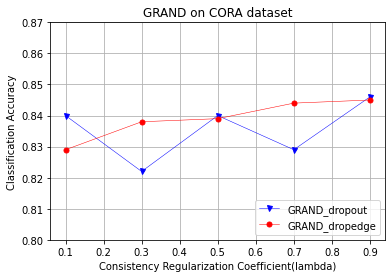

In [ ]:
x = [i/10 for i in range(1,11,2)]
plt.plot(x, accs_dropout, "bv",linestyle="solid", linewidth=0.5, label="GRAND_dropout", markersize=5)
plt.plot(x, accs_dropedge, "ro", linestyle="solid", linewidth=0.5, label="GRAND_dropedge", markersize=5)
plt.grid()
plt.legend(loc="lower right")
plt.xlabel("Consistency Regularization Coefficient(lambda)")
plt.ylabel("Classification Accuracy")
plt.ylim(0.80, 0.87)
plt.title(f"GRAND on {args['dataset'].upper()} dataset")
plt.savefig("Acc v CR lambda.png")
plt.show()

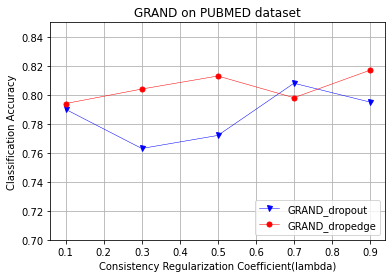

In [ ]:
x = [i/10 for i in range(1,11,2)]
plt.plot(x, accs_dropout, "bv",linestyle="solid", linewidth=0.5, label="GRAND_dropout", markersize=5)
plt.plot(x, accs_dropedge, "ro", linestyle="solid", linewidth=0.5, label="GRAND_dropedge", markersize=5)
plt.grid()
plt.legend(loc="lower right")
plt.xlabel("Consistency Regularization Coefficient(lambda)")
plt.ylabel("Classification Accuracy")
plt.ylim(0.70, 0.85)
plt.title(f"GRAND on {args['dataset'].upper()} dataset")
plt.savefig("Acc v CR lambda_pubmed.png")
plt.show()

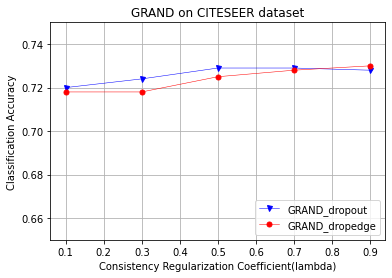

In [ ]:
x = [i/10 for i in range(1,11,2)]
plt.plot(x, accs_dropout, "bv",linestyle="solid", linewidth=0.5, label="GRAND_dropout", markersize=5)
plt.plot(x, accs_dropedge, "ro", linestyle="solid", linewidth=0.5, label="GRAND_dropedge", markersize=5)
plt.grid()
plt.legend(loc="lower right")
plt.xlabel("Consistency Regularization Coefficient(lambda)")
plt.ylabel("Classification Accuracy")
plt.ylim(0.65, 0.75)
plt.title(f"GRAND on {args['dataset'].upper()} dataset")
plt.savefig("Acc v CR lambda_citeseer.png")
plt.show()

In [ ]:
accs_dropedge = []
for sample in range(1,5):
  acc_sample = []
  for order in range(1,11):
    Train(sample=sample, order=order) #dropedge 
    acc_sample.append(test(order=order))
  accs_dropedge.append(acc_sample)

Streaming output truncated to the last 5000 lines.
Epoch: 0720 loss_train: 0.7354 acc_train: 0.8357 loss_val: 0.6835 acc_val: 0.8300 time: 0.0152s
173
Epoch: 0721 loss_train: 0.6995 acc_train: 0.8429 loss_val: 0.6780 acc_val: 0.8300 time: 0.0140s
174
Epoch: 0722 loss_train: 0.7339 acc_train: 0.8714 loss_val: 0.6734 acc_val: 0.8280 time: 0.0139s
175
Epoch: 0723 loss_train: 0.7493 acc_train: 0.8000 loss_val: 0.6714 acc_val: 0.8280 time: 0.0140s
176
Epoch: 0724 loss_train: 0.7537 acc_train: 0.8429 loss_val: 0.6711 acc_val: 0.8280 time: 0.0139s
177
Epoch: 0725 loss_train: 0.7571 acc_train: 0.8357 loss_val: 0.6733 acc_val: 0.8300 time: 0.0141s
178
Epoch: 0726 loss_train: 0.7531 acc_train: 0.8786 loss_val: 0.6766 acc_val: 0.8300 time: 0.0145s
179
Epoch: 0727 loss_train: 0.7488 acc_train: 0.8786 loss_val: 0.6814 acc_val: 0.8260 time: 0.0136s
180
Epoch: 0728 loss_train: 0.7738 acc_train: 0.8214 loss_val: 0.6867 acc_val: 0.8240 time: 0.0135s
181
Epoch: 0729 loss_train: 0.7207 acc_train: 0.8143 

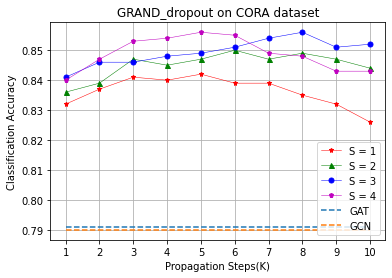

In [ ]:
x = [i for i in range(1, 11)]
plt.plot(x, accs_dropedge[0], "r*", linestyle="solid", linewidth=0.5, label="S = 1", markersize=5)
plt.plot(x, accs_dropedge[1], "g^", linestyle="solid", linewidth=0.5, label="S = 2", markersize=5)
plt.plot(x, accs_dropedge[2], "bo", linestyle="solid", linewidth=0.5, label="S = 3", markersize=5)
plt.plot(x, accs_dropedge[3], "mp", linestyle="solid", linewidth=0.5, label="S = 4", markersize=5)
plt.plot(x, [0.791 for _ in range(10)], linestyle="dashed", label="GAT")
plt.plot(x, [0.79 for _ in range(10)], linestyle="dashed", label="GCN")
plt.xticks(np.arange(1, len(x)+1, 1))
plt.grid()
plt.legend(loc="lower right")
plt.xlabel("Propagation Steps(K)")
plt.ylabel("Classification Accuracy")
# plt.ylim(0.74, 0.87)
plt.title(f"GRAND_dropout on {args['dataset'].upper()} dataset")
plt.savefig(f"{args['dataset']}.png")
plt.show()